## Importing Required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualizing data
import seaborn as sns # visualizing data with stunning default theme
import sklearn 
import warnings # to handle warnings
warnings.filterwarnings('ignore') #to ignore all warnings

## Data Extraction and Visualization

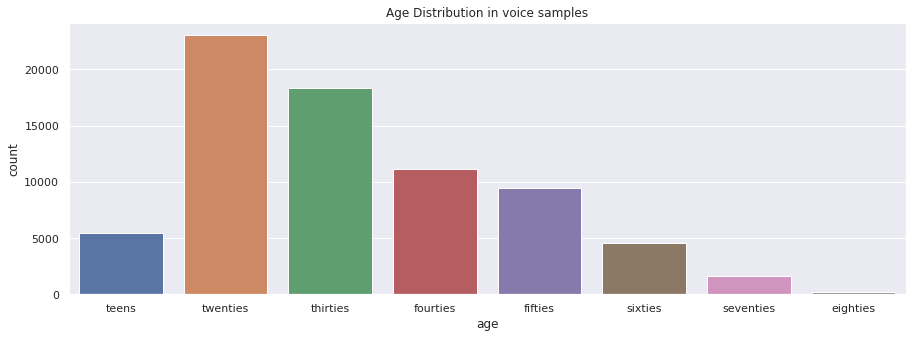

In [2]:
df = pd.read_csv("../input/common-voice/cv-valid-train.csv") 
df[df['age'].notna()].head()
sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="age", 
        data=df[df['age'].notna()], 
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])
plt.title("Age Distribution in voice samples")
plt.show()

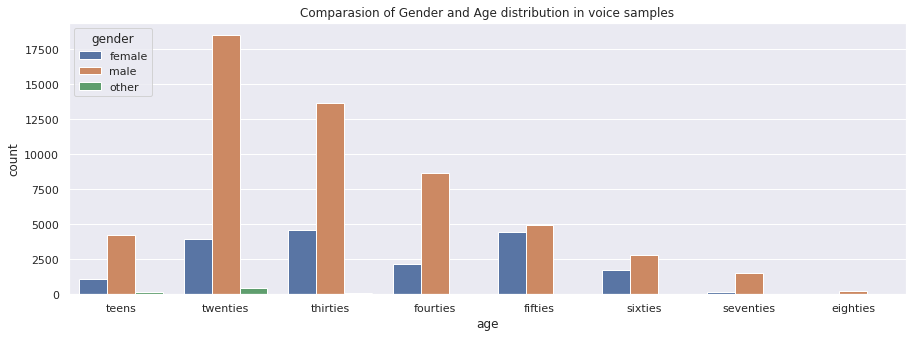

In [3]:
sns.countplot(x="age", 
        hue='gender',
        data=df[df['age'].notna()],
        order=['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.title("Comparasion of Gender and Age distribution in voice samples")
plt.show()

## Data Pre-Processing

### Data cleaning

In [4]:
#Removing Nan values
df = df[['filename','age','gender']]
data = df[df['age'].notna() & df['gender'].notna()]
data.reset_index(inplace=True, drop=True)
data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female
3,cv-valid-train/sample-000014.mp3,sixties,male
4,cv-valid-train/sample-000019.mp3,fifties,male


In [5]:
# Discretizing gender values
cleanup_nums = {"gender": {"male":1,"female":0,"other":0.5}}
data = data.replace(cleanup_nums)
data.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,0.0
1,cv-valid-train/sample-000008.mp3,seventies,1.0
2,cv-valid-train/sample-000013.mp3,thirties,0.0
3,cv-valid-train/sample-000014.mp3,sixties,1.0
4,cv-valid-train/sample-000019.mp3,fifties,1.0


## Feature Engineering with librosa library

### Feature extraction

In [6]:
import librosa
ds_path = "/kaggle/input/common-voice/cv-valid-train/"

In [7]:
#utility function to extract audio frequency features
def feature_extraction(filename, sampling_rate=48000):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    
    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features

In [8]:
# sample extraction
features = feature_extraction(data.iloc[0]['filename'])
print("features: ", features)

features:  [0.0, 2679.9393008845423, 3347.66922960854, 5745.486745886655, -625.21814, 111.32094, 6.326995, 34.757614, 31.619902, -4.714648, -0.4860331, -4.9340267, -12.714735, -2.0551496, -3.741118, -10.702963, -11.202636, -12.003523, -8.489579, -5.463276, -4.9542174, -3.7152, -6.330531, -6.338476]


In [9]:
# taking only few samples of data due to lack of resources 
data = data.sample(frac=0.013611738763509651)

In [10]:
#a utility function that stores the extracted features in the dataframe
def create_df_features(orig):
    new_rows = list()
    
    for _, row in orig.iterrows():
        features = feature_extraction(row['filename'])
        features.append(row['age'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                    "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                   "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                   "mfcc17", "mfcc18", "mfcc19", "mfcc20", "label"])
  
df_features = create_df_features(data)
df_features.head()

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,1.0,2540.938317,2505.817638,4870.778339,-317.560181,134.976151,-33.398121,41.523724,21.854490,10.092053,...,-4.265806,6.766406,6.687577,-3.913382,-3.396795,-2.471499,0.111037,-0.113026,-2.192567,fifties
1,1.0,1882.798491,2275.924132,3445.998476,-389.017303,135.735580,4.766262,40.524456,19.675434,16.239742,...,-2.231459,-10.109211,-14.846977,-8.766885,-10.489201,-6.698781,-0.253304,-1.846977,-5.374200,sixties
2,1.0,1267.942695,1878.505052,2388.419859,-336.550476,176.242783,15.129741,4.245973,5.586239,16.138332,...,4.132156,12.597640,7.908283,3.422878,2.949585,11.706362,10.387835,3.972884,1.984096,thirties
3,1.0,2437.147313,2531.913920,4632.925316,-339.763062,124.028687,7.507048,24.858807,5.260570,6.164420,...,0.904804,-8.463137,-14.469934,-1.653091,-6.235259,-4.108103,3.072848,-5.595485,-6.045145,teens
4,1.0,3112.539905,2764.390495,5890.579971,-406.638428,118.908501,-23.923674,22.990116,7.151540,9.225325,...,6.662714,-14.218515,-0.976323,1.255886,-3.778939,-3.925484,-2.790482,3.990886,-2.899721,fourties


## Gender Classification 

In [11]:
X = df_features.drop(columns = ["gender","label"]).to_numpy()
y = df_features["gender"].to_numpy().reshape((X.shape[0],1))

y = y.astype(np.int32)

In [12]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2, random_state=23, shuffle=True, stratify=y)

In [13]:
#building and training the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)

model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [14]:
from sklearn.metrics import f1_score, accuracy_score
y_predicted = model.predict(X_test)
print(f"Accuracy of gender classification achieved: {accuracy_score(y_test,y_predicted)*100}%")
print(f"F1 score of gender classification achieved: {f1_score(y_test,y_predicted)*100}%")

Accuracy of gender classification achieved: 85.0%
F1 score of gender classification achieved: 90.9090909090909%


<AxesSubplot:>

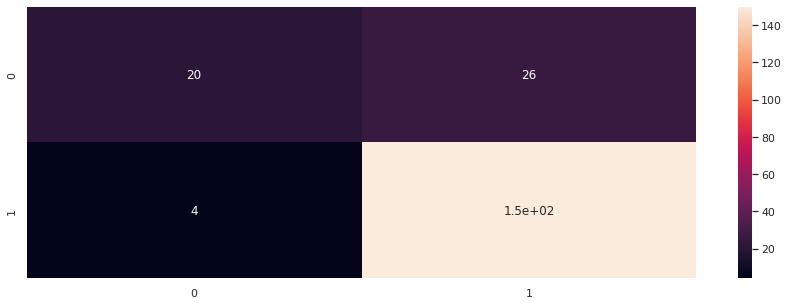

In [15]:
c_map = sklearn.metrics.confusion_matrix(y_test,y_predicted)
sns.heatmap(c_map,annot=True)

## Age Classification

In [16]:
X = df_features.drop(columns = ["gender","label"]).to_numpy()
y = df_features["label"].to_numpy()
le = sklearn.preprocessing.LabelEncoder()
y = le.fit_transform(y).reshape((X.shape[0],1))

In [17]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size=0.2, random_state=23, shuffle=True, stratify=y)

In [18]:
#building and training the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000)

model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [19]:
from sklearn.metrics import f1_score, accuracy_score
y_predicted = model.predict(X_test)
print(f"Accuracy of gender classification achieved: {accuracy_score(y_test,y_predicted)*100}%")
print(f"F1 score of gender classification achieved: {f1_score(y_test,y_predicted,average='weighted')*100}%")

Accuracy of gender classification achieved: 43.0%
F1 score of gender classification achieved: 38.2665040066322%


<AxesSubplot:>

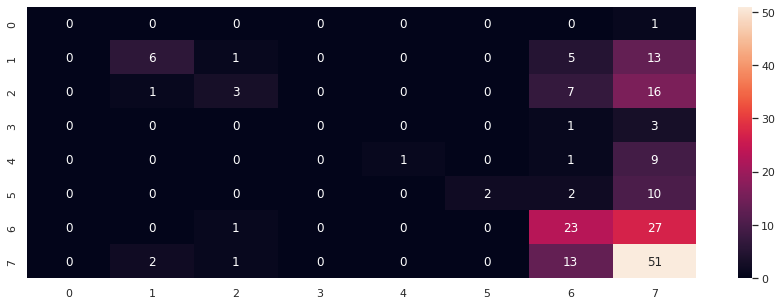

In [20]:
c_map = sklearn.metrics.confusion_matrix(y_test,y_predicted)
sns.heatmap(c_map,annot=True)